In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [3]:

import numpy as np
from torchviz import make_dot
from graphviz import Source
from IPython.display import Image, display

from math import ceil, floor
from torch import Tensor
import torch

import wandb
import torch.nn.functional as F
import math
import torch
import torch.nn as nn
import torch.nn.utils.parametrize as parametrize
from torch.autograd import Function
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from src.utils_quantization import FakeQuantParametrization, attach_weight_quantizers, toggle_quantization 

In [ ]:
import torch.nn.functional as F

def train(model, device, train_loader, optimizer, epoch,
          lambda_linear=0.0, lambda_conv=0.0):
    model.train()
    correct = 0
    total = 0
    total_loss = 0.0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        ce_loss = F.cross_entropy(output, target)

        # add structured sparsity regularization
        reg_loss = structured_sparsity_reg(
            model,
            lambda_linear=lambda_linear,
            lambda_conv=lambda_conv,
        )

        loss = ce_loss + reg_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * target.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return accuracy, avg_loss


def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)

            total_loss += loss.item() * target.size(0)  # accumulate total loss
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return accuracy, avg_loss

def build_dataset(TRAIN_SIZE):
    # DATA
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    # Load full training dataset
    full_train_dataset = datasets.MNIST('../notebooks_new/data', train=True, download=True, transform=transform)
    
    # Calculate the size of the subset (10%)
    subset_size = int(TRAIN_SIZE * len(full_train_dataset))
    remaining_size = len(full_train_dataset) - subset_size
    
    # Split the dataset
    train_subset, _ = random_split(full_train_dataset, [subset_size, remaining_size])
    
    # Create DataLoader for the subset
    train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
    
    # Test loader remains the same
    test_loader = DataLoader(datasets.MNIST('../notebooks_new/data', train=False, transform=transform),
                             batch_size=1000, shuffle=False)
    return train_loader, test_loader

class QuantMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.width = 32
        self.fc1 = nn.Linear(28 * 28, self.width)
        self.fc2 = nn.Linear(self.width, self.width)
        self.fc3 = nn.Linear(self.width, self.width)
        self.fc4 = nn.Linear(self.width, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class QuantMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.width = 32
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc2 = nn.Linear(8 * 14 * 14, self.width)
        self.fc3 = nn.Linear(self.width, self.width)
        self.fc4 = nn.Linear(self.width, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Flatten for FC layers
        x = x.view(x.size(0), -1)

        # MLP layers
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

class QuantMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.width = 32
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc2 = nn.Linear(8 * 14 * 14, 16)
        self.fc3 = nn.Linear(16, self.width)
        self.fc4 = nn.Linear(self.width, 10)

    def forward(self, x):
        # conv output (pre-pool) — record spatial dims for MAC counting
        x = self.conv1(x)
        oh, ow = x.shape[-2], x.shape[-1]
        self.conv1.out_h = int(oh)
        self.conv1.out_w = int(ow)

        x = F.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

@torch.no_grad()
def quantized_weights(model: nn.Module, zero_eps: float = 0.0) -> float:
    vals = []
    for mod in model.modules():
        if parametrize.is_parametrized(mod, "weight"):
            plist = mod.parametrizations["weight"]
            if any(isinstance(p, FakeQuantParametrization) for p in plist):
                Wq = mod.weight  # goes through the FakeQuantParametrization
                vals.append(Wq.detach().clone().cpu().numpy())
    return vals

@torch.no_grad()
def sparsity(model: nn.Module, zero_eps: float = 0.0) -> float:
    vals = []
    for mod in model.modules():
        if parametrize.is_parametrized(mod, "weight"):
            plist = mod.parametrizations["weight"]
            if any(isinstance(p, FakeQuantParametrization) for p in plist):
                Wq = mod.weight  # goes through the FakeQuantParametrization
                if zero_eps > 0.0:
                    nz = (Wq.abs() > zero_eps).sum().item()
                else:
                    nz = (Wq != 0).sum().item()
                vals.append(1 - nz / float(Wq.numel()))
    return vals

@torch.no_grad()
def deadzones_logits(model) -> float:
    ds = []
    for m in model.modules():
        if isinstance(m, FakeQuantParametrization):
            d = m.quantizer.get_deadzone_logit()
            ds.append(d.item() if torch.is_tensor(d) else float(d))
    return ds

@torch.no_grad()
def bitwidths_logits(model) -> float:
    ds = []
    for m in model.modules():
        if isinstance(m, FakeQuantParametrization):
            d = m.quantizer.get_bitwidth_logit()
            ds.append(d.item() if torch.is_tensor(d) else float(d))
    return ds

@torch.no_grad()
def bitwidths(model) -> float:
    ds = []
    for m in model.modules():
        if isinstance(m, FakeQuantParametrization):
            d = m.quantizer.get_bitwidth()
            ds.append(d.item() if torch.is_tensor(d) else float(d))
    return ds

class FloorSTE(Function):
    @staticmethod
    def forward(ctx, input):
        # Forward: use normal floor
        return torch.floor(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

class SignSTE(Function):
    @staticmethod
    def forward(ctx, input):
        return input.sign()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

class RoundSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

def torch_quantile(
    tensor: Tensor,
    q,
    dim = None,
    *,
    keepdim: bool = False,
    interpolation: str = "linear",
    out= None,
) -> Tensor:
    r"""Improved ``torch.quantile`` for one scalar quantile.
    Arguments
    ---------
    tensor: ``Tensor``
        See ``torch.quantile``.
    q: ``float``
        See ``torch.quantile``. Supports only scalar values currently.
    dim: ``int``, optional
        See ``torch.quantile``.
    keepdim: ``bool``
        See ``torch.quantile``. Supports only ``False`` currently.
        Defaults to ``False``.
    interpolation: ``{"linear", "lower", "higher", "midpoint", "nearest"}``
        See ``torch.quantile``. Defaults to ``"linear"``.
    out: ``Tensor``, optional
        See ``torch.quantile``. Currently not supported.
    Notes
    -----
    Uses ``torch.kthvalue``. Better than ``torch.quantile`` since:
    #. it has no :math:`2^{24}` tensor `size limit <https://github.com/pytorch/pytorch/issues/64947#issuecomment-2304371451>`_;
    #. it is much faster, at least on big tensor sizes.
    """
    # Sanitization of: q
    q_float = float(q)  # May raise an (unpredictible) error
    if not 0 <= q_float <= 1:
        msg = f"Only values 0<=q<=1 are supported (got {q_float!r})"
        raise ValueError(msg)
    # Sanitization of: dim
    # Because one cannot pass  `dim=None` to `squeeze()` or `kthvalue()`
    if dim_was_none := dim is None:
        dim = 0
        tensor = tensor.reshape((-1, *(1,) * (tensor.ndim - 1)))
    # Sanitization of: inteporlation
    idx_float = q_float * (tensor.shape[dim] - 1)
    if interpolation == "nearest":
        idxs = [round(idx_float)]
    elif interpolation == "lower":
        idxs = [floor(idx_float)]
    elif interpolation == "higher":
        idxs = [ceil(idx_float)]
    elif interpolation in {"linear", "midpoint"}:
        low = floor(idx_float)
        idxs = [low] if idx_float == low else [low, low + 1]
        weight = idx_float - low if interpolation == "linear" else 0.5
    else:
        msg = (
            "Currently supported interpolations are {'linear', 'lower', 'higher', "
            f"'midpoint', 'nearest'}} (got {interpolation!r})"
        )
        raise ValueError(msg)
    # Sanitization of: out
    if out is not None:
        msg = f"Only None value is currently supported for out (got {out!r})"
        raise ValueError(msg)
    # Logic
    outs = [torch.kthvalue(tensor, idx + 1, dim, keepdim=True)[0] for idx in idxs]
    out = outs[0] if len(outs) == 1 else outs[0].lerp(outs[1], torch.tensor(weight, device=outs[0].device))
    # Rectification of: keepdim
    if keepdim:
        return out
    return out.squeeze() if dim_was_none else out.squeeze(dim)


class ClampSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lo, hi):
        return torch.clamp(x, min=lo, max=hi)

    @staticmethod
    def backward(ctx, g):
        return g, None, None


class ReluSTE(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        # normal ReLU in the forward
        return x.clamp(min=0)

    @staticmethod
    def backward(ctx, grad_output):
        # STE: pretend d(ReLU)/dx = 1 for all x
        grad_input = grad_output
        return grad_input


class ClampNoGradBounds(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lower, upper):
        ctx.save_for_backward(x, lower, upper)
        return x.clamp(min=lower, max=upper)

    @staticmethod
    def backward(ctx, grad_output):
        x, lower, upper = ctx.saved_tensors
        # normal clamp gradient for x
        grad_x = grad_output.clone()
        grad_x[x < lower] = 0
        grad_x[x > upper] = 0

        # no gradients for bounds
        #grad_lower = None
        #grad_upper = None
        return grad_x, None, None

In [ ]:
# class DeadZoneLDZ(nn.Module):
#     def __init__(self, fixed_bit_val=4, max_bits=8, init_bit_logit=3.0, init_deadzone_logit=3.0, learnable_bit=True, learnable_deadzone=True):
#         super().__init__()
#         
#         # Learnable params
#         self.logit_dz = nn.Parameter(torch.tensor(init_deadzone_logit), requires_grad=learnable_deadzone)
#         self.logit_bit = nn.Parameter(torch.tensor(init_bit_logit), requires_grad=learnable_bit)
#         
#         # Register buffers
#         self.register_buffer("fixed_bit", torch.tensor(float(fixed_bit_val)))
#         self.register_buffer("max_bits", torch.tensor(float(max_bits)))
#         self.register_buffer("min_bits", torch.tensor(2.0))
#         self.register_buffer("learnable_bit", torch.tensor(float(learnable_bit)))
#         self.register_buffer("learnable_deadzone", torch.tensor(float(learnable_deadzone)))
# 
#         # flags
#         self.learnable_bit_flag = learnable_bit
#         self.learnable_deadzone_flag = learnable_deadzone
# 
#     def _get_bitwidth(self):
#         """ Uses Learnable bit else fixed bit """
#         if self.learnable_bit_flag:
#             bit_budget = self.max_bits - self.min_bits
#             b_cont = bit_budget * torch.tanh(self.logit_bit).abs() + self.min_bits
#             B = RoundSTE.apply(b_cont)
#         else:
#             B = self.fixed_bit
#         return B
# 
#     def _get_deadzone(self, absmax):
#         eps = 1e-8
#         return 2.0 * absmax * (1 - torch.tanh(self.logit_dz).abs()) - eps 
# 
#     def _get_absmax(self, w):
#         absmax = torch_quantile(w.abs(), 0.99)
#         return absmax
# 
#     def _get_step_size(self, absmax, d, Q):
#         return ((absmax - d / 2.0)) / (Q - 0.5)
# 
#     @torch.no_grad()
#     def get_bitwidth(self):
#         return self._get_bitwidth().clone().cpu()
# 
#     @torch.no_grad()
#     def get_deadzone_logit(self):
#         return self.logit_dz.detach().clone().cpu()
# 
#     @torch.no_grad()
#     def get_bitwidth_logit(self):
#         return self.logit_bit.detach().clone().cpu()
# 
#     def forward(self, w: torch.Tensor) -> torch.Tensor:
#         # Dont track grad for quantile absmax
#         with torch.no_grad():
#             absmax = self._get_absmax(w)
# 
#         # Quantization parameters
#         B = self._get_bitwidth()
#         d = self._get_deadzone(absmax)
#         
#         # Step size
#         Q = torch.pow(torch.tensor(2.0, device=w.device, dtype=w.dtype), B - 1.0) - 1.0
#         s = self._get_step_size(absmax, d, Q)
# 
#         #shift = d/2 - s/2
#         #w_comp = torch.sign(w) * ReluSTE.apply(w.abs() - shift)
#         #q = ClampSTE.apply(RoundSTE.apply(w_comp / s), -Q, Q)
#         #w_expand = s * q + shift * torch.sign(q)
#         #w_hat = w_expand
#         
#         #Offset term
#         delta = (0.5 * (1 - d / s))
# 
#         # Quantize
#         w_bar = torch.sign(w) * ClampSTE.apply(RoundSTE.apply((w.abs() / s) + delta), torch.zeros(1).to(w.device), Q)
#         w_hat = s * (w_bar - torch.sign(w_bar) * delta)
#         return w_hat

class DeadZoneLDZ(nn.Module):
    def __init__(self, fixed_bit_val=4, max_bits=8, init_bit_logit=3.0, init_deadzone_logit=3.0, learnable_bit=True,
                 learnable_deadzone=True):
        super().__init__()

        # Learnable params
        self.logit_dz = nn.Parameter(torch.tensor(init_deadzone_logit), requires_grad=learnable_deadzone)
        self.logit_bit = nn.Parameter(torch.tensor(init_bit_logit), requires_grad=learnable_bit)

        # Register buffers
        self.register_buffer("fixed_bit", torch.tensor(float(fixed_bit_val)))
        self.register_buffer("max_bits", torch.tensor(float(max_bits)))
        self.register_buffer("min_bits", torch.tensor(2.0))
        self.register_buffer("learnable_bit", torch.tensor(float(learnable_bit)))
        self.register_buffer("learnable_deadzone", torch.tensor(float(learnable_deadzone)))

        # flags
        self.learnable_bit_flag = learnable_bit
        self.learnable_deadzone_flag = learnable_deadzone

    def _get_bitwidth(self):
        """ Uses Learnable bit else fixed bit """
        if self.learnable_bit_flag:
            bit_budget = self.max_bits - self.min_bits
            b_cont = bit_budget * torch.tanh(self.logit_bit).abs() + self.min_bits
            B = RoundSTE.apply(b_cont)
        else:
            B = self.fixed_bit
        return B

    def _get_deadzone(self, absmax):
        return 2.0 * absmax * (1 - torch.tanh(self.logit_dz).abs())

    def _get_absmax(self, w):
        absmax = torch_quantile(w.abs(), 0.99)
        return absmax

    def _get_step_size(self, absmax, d, Q):
        eps = 1e-8
        return (absmax - d / 2.0) / (Q - 0.5) + eps

    @torch.no_grad()
    def get_bitwidth(self):
        return self._get_bitwidth().clone().cpu()

    @torch.no_grad()
    def get_deadzone_logit(self):
        return self.logit_dz.detach().clone().cpu()

    @torch.no_grad()
    def get_bitwidth_logit(self):
        return self.logit_bit.detach().clone().cpu()

    def forward(self, w: torch.Tensor) -> torch.Tensor:
        # Dont track grad for quantile absmax
        with torch.no_grad():
            absmax = self._get_absmax(w)

        # Quantization parameters
        B = self._get_bitwidth()
        d = self._get_deadzone(absmax)

        # Step size
        Q = torch.pow(torch.tensor(2.0, device=w.device, dtype=w.dtype), B - 1.0) - 1.0
        s = self._get_step_size(absmax, d, Q)
        
        # Quantize
        shift = d/2 - s/2
        w_comp = torch.sign(w) * ReluSTE.apply(w.abs() - shift)
        q = ClampSTE.apply(RoundSTE.apply(w_comp / s), -Q, Q)
        w_hat = s * q + shift * torch.sign(q)
        return w_hat

In [ ]:
def structured_sparsity_reg(model, lambda_linear=1e-4, lambda_conv=1e-4):
    reg = 0.0
    for m in model.modules():
        if isinstance(m, nn.Linear):
            W = m.weight  # [out, in]
            reg = reg + lambda_linear * torch.norm(W, dim=0).sum()
            #print(m, reg)
            #reg = reg + lambda_linear * torch.norm(W, dim=1).sum()
        elif isinstance(m, nn.Conv2d):
            W = m.weight  # [out_c, in_c, kH, kW]
            # Flatten each filter to vector then one group per output channel
            W_flat = W.view(W.size(0), -1)  # [out_c, in_c*kH*kW]
            reg = reg + lambda_conv * torch.norm(W_flat, dim=0).sum()
            #reg = reg + lambda_conv * torch.norm(W_flat, dim=1).sum()
    return reg

device = torch.device("mps")#torch.device("cuda" if torch.cuda.is_available() else "mps")
TRAIN_SIZE = 0.05
EPOCHS = 40
MOMENTUM = 0.9

LR_BASE = 0.001
LR_DZ = 0.001
LR_BIT = 0.001

WD = 0.0
WD_DZ = 2.5 #2.5
WD_BIT = 0.0 #2.5
REG_STRUCTURED = 0.1
QUANT_ARGS = {"fixed_bit_val": 8, "init_deadzone_logit": 3.0, "max_bits": 8, "learnable_deadzone": True, "learnable_bit": False}


# wandb.init(project="quant-mlp-training", config={
#     "train_size": TRAIN_SIZE,
#     "epochs": EPOCHS,
#     "lr_base": LR_BASE,
#     "lr_dz": LR_DZ,
#     "lr_bit": LR_BIT,
#     "weight_decay": WD,
#     "momentum": MOMENTUM,
#     "quant_args": QUANT_ARGS
# })

model = QuantMLP()
attach_weight_quantizers(model=model,exclude_layers=[],quantizer=DeadZoneLDZ,quantizer_kwargs=QUANT_ARGS,enabled=True)
model.to(device)
#wandb.watch(model, log="all", log_freq=1)
#print(compute_bops(model=model, example_input=torch.randn(1, 1, 28, 28).to("mps")))

base_params = []
dz_params = []
bit_params = []

for name, param in model.named_parameters():
    if 'logit_dz' in name:
        dz_params.append(param)
    elif 'logit_bit' in name:
        bit_params.append(param)
    else:
        base_params.append(param)

optimizer = torch.optim.AdamW([
    {'params': base_params, 'lr': LR_BASE, 'weight_decay': WD},
    {'params': dz_params, 'lr': LR_DZ, 'weight_decay': WD_DZ},
    {'params': bit_params, 'lr': LR_BIT, 'weight_decay': WD_BIT},
])

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

train_loader, test_loader = build_dataset(TRAIN_SIZE)

train_accs, val_accs = [], []
train_losses, val_losses = [], []

toggle_quantization(model, enabled=True)

for epoch in range(0, EPOCHS): 
    #bops = compute_bops(model=model, example_input=torch.randn(1, 1, 28, 28).to("mps"))
    #print(bops)

    #train_acc, train_loss = train(model, device, train_loader, optimizer, epoch)
    train_acc, train_loss = train(model, device, train_loader, optimizer, epoch, lambda_linear=REG_STRUCTURED, lambda_conv=REG_STRUCTURED)

    #lr_scheduler.step()
    
    val_acc, val_loss = test(model, device, test_loader)
    
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    deadz = deadzones_logits(model)
    bitz = bitwidths_logits(model)
    bitint = bitwidths(model)
    sparse = sparsity(model)
    qw = quantized_weights(model)
    
    mean_deadzone = np.mean(deadz) if len(deadz) > 0 else float("nan")
    mean_bitz = np.mean(bitz) if len(bitz) > 0 else float("nan")
    mean_bitint = np.mean(bitint) if len(bitint) > 0 else float("nan")
    mean_sparsity = np.mean(sparse) if len(sparse) > 0 else float("nan")
    
    # log_dict = {
    #     "epoch": epoch,
    #     "train_acc": train_acc,
    #     "val_acc": val_acc,
    #     "train_loss": train_loss,
    #     "val_loss": val_loss,
    #     "mean_deadzone": mean_deadzone,
    #     "mean_bitwidth": mean_bitz,
    #     "mean_bitwidth_int": mean_bitint,
    #     "mean_sparsity": mean_sparsity,
    #     #"bops": bops
    # }
    # 
    # for i, d in enumerate(deadz):
    #     log_dict[f"deadzone logits/layer_{i}"] = d
    # for i, d in enumerate(bitz):
    #     log_dict[f"bitwidth logits/layer_{i}"] = d
    # for i, d in enumerate(bitint):
    #     log_dict[f"bitwidth ints/layer_{i}"] = d
    # for i, s in enumerate(sparse):
    #     log_dict[f"sparsity/layer_{i}"] = s
    # for i, p in enumerate(bit_params):
    #     if p.grad is not None:
    #         log_dict[f"bit_grad/layer_{i}"] = p.grad.item()
    # for i, p in enumerate(dz_params):
    #     if p.grad is not None:
    #         log_dict[f"dz_grad/layer_{i}"] = p.grad.item()
    # for i, w in enumerate(qw):
    #     log_dict[f"Qweights/layer_{i}"] = wandb.Histogram(w.flatten())
    #     log_dict[f"Qweights/unique_layer_{i}"] = len(np.unique(w.flatten()))
    #     
    # wandb.log(log_dict)

    print(
        f"Epoch {epoch}: "
        f"Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}, "
        #f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
        f"Mean Deadzone = {mean_deadzone:.4f}, Mean bithwdtih = {mean_bitz:.4f}, "
        f"Mean bitwidth int = {mean_bitint:.4f}, Mean Sparsity = {mean_sparsity:.4f}"
    )

wandb.finish()

Attached weight quantizer to layer: conv1
Attached weight quantizer to layer: fc2
Attached weight quantizer to layer: fc3
Attached weight quantizer to layer: fc4
Epoch 0: Train Acc = 0.1970, Val Acc = 0.1176, Mean Deadzone = 2.8284, Mean bithwdtih = 3.0000, Mean bitwidth int = 8.0000, Mean Sparsity = 0.0169
Epoch 1: Train Acc = 0.1067, Val Acc = 0.0980, Mean Deadzone = 2.6721, Mean bithwdtih = 3.0000, Mean bitwidth int = 8.0000, Mean Sparsity = 0.0656
Epoch 2: Train Acc = 0.1057, Val Acc = 0.0980, Mean Deadzone = 2.5265, Mean bithwdtih = 3.0000, Mean bitwidth int = 8.0000, Mean Sparsity = 0.1510
Epoch 3: Train Acc = 0.1057, Val Acc = 0.0980, Mean Deadzone = 2.3913, Mean bithwdtih = 3.0000, Mean bitwidth int = 8.0000, Mean Sparsity = 0.2085
Epoch 4: Train Acc = 0.1057, Val Acc = 0.0980, Mean Deadzone = 2.2649, Mean bithwdtih = 3.0000, Mean bitwidth int = 8.0000, Mean Sparsity = 0.2940
Epoch 5: Train Acc = 0.1057, Val Acc = 0.0980, Mean Deadzone = 2.1455, Mean bithwdtih = 3.0000, Mean bi

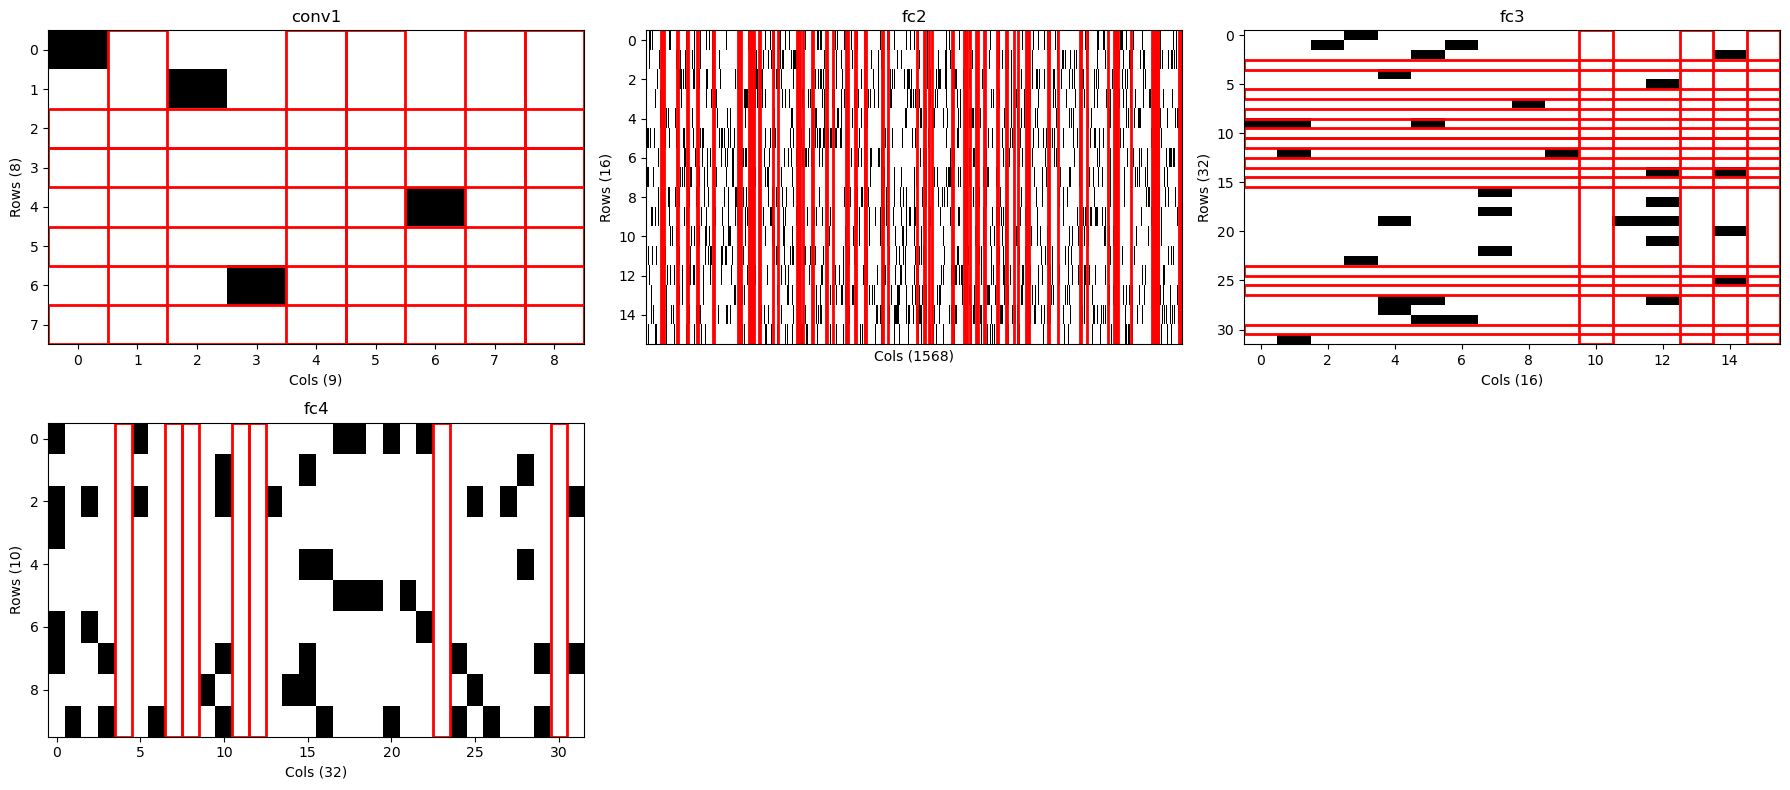

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_all_sparsity_layers(layer_masks, layer_names):
    """
    layer_masks: list of 2D boolean masks [out, in], 1 = non-zero
    layer_names: list of layer names
    """

    n = len(layer_masks)
    cols = min(3, n)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(
        rows, cols,
        figsize=(6 * cols, 4 * rows),
        squeeze=False
    )

    for idx, (mask, name) in enumerate(zip(layer_masks, layer_names)):
        r = idx // cols
        c = idx % cols
        ax = axes[r][c]

        mask = mask.cpu().numpy().astype(float)
        H, W = mask.shape

        # Show the binary non-zero matrix
        ax.imshow(
            mask,
            cmap="gray_r",      # 1 = black (nonzero), 0 = white (zero)
            interpolation="nearest",
            aspect="auto",
            vmin=0, vmax=1,
        )

        ax.set_title(name)
        ax.set_xlabel(f"Cols ({W})")
        ax.set_ylabel(f"Rows ({H})")

        # Fully zero rows/cols
        row_zero = (mask.sum(axis=1) == 0)
        col_zero = (mask.sum(axis=0) == 0)

        # Highlight rows
        for row_i, is_zero in enumerate(row_zero):
            if is_zero:
                ax.axhspan(row_i - 0.5, row_i + 0.5,
                           facecolor="none", edgecolor="red", linewidth=2)

        # Highlight columns
        for col_i, is_zero in enumerate(col_zero):
            if is_zero:
                ax.axvspan(col_i - 0.5, col_i + 0.5,
                           facecolor="none", edgecolor="red", linewidth=2)

        # Hide tick labels if matrix is large
        if H > 40:
            ax.set_yticks([])
        if W > 40:
            ax.set_xticks([])

    # Remove unused subplots
    for idx in range(n, rows * cols):
        fig.delaxes(axes[idx // cols][idx % cols])

    fig.tight_layout()
    plt.show()

@torch.no_grad()
def sparsity_stats(model, zero_eps: float = 0.0, plot=True):
    stats = []
    layer_masks = []
    layer_names = []

    for name, mod in model.named_modules():
        if not parametrize.is_parametrized(mod, "weight"):
            continue

        plist = mod.parametrizations["weight"]
        if not any(isinstance(p, FakeQuantParametrization) for p in plist):
            continue

        Wq = mod.weight

        # Boolean mask: 1 = nonzero, 0 = zero
        if zero_eps > 0.0:
            mask_nz = (Wq.abs() > zero_eps)
        else:
            mask_nz = (Wq != 0)

        mask2d = mask_nz.view(Wq.size(0), -1)

        # Sparsity stats
        nz = mask2d.sum().item()
        total = mask2d.numel()
        global_sparsity = 1.0 - nz / total

        row_sparsity = 1.0 - mask2d.float().mean(dim=1)
        col_sparsity = 1.0 - mask2d.float().mean(dim=0)

        stats.append({
            "name": name,
            "shape": tuple(Wq.shape),
            "global_sparsity": float(global_sparsity),
            "row_sparsity": row_sparsity.cpu(),
            "col_sparsity": col_sparsity.cpu(),
        })

        layer_masks.append(mask2d)
        layer_names.append(name)

    # Plot everything in ONE figure
    if plot:
        plot_all_sparsity_layers(layer_masks, layer_names)

    return stats

stats = sparsity_stats(model, zero_eps=0.0, plot=True)